In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math
from numba import njit

In [12]:
WN = np.loadtxt('W_avg.csv')
Cave = np.loadtxt('Cave.csv')
pop = np.loadtxt('pop_new.csv')

In [13]:
num_fips = len(pop)
T = 60
num_ens = 300

In [14]:
Z = 3 # latent period
Zb = 1 # scale parameter for Z
D = 5 # infectious period
Db = 1 # scale parameter for b
alpha = 0.1 # reporting rate 10%

In [15]:
# seeding
l0 = 1859-1 # start with New York County NY in python -1, in matlab is 1859
i0 = 100 ## the starting t=0, in matlab it is 1
initials = (l0,i0)

In [16]:
x_cutoff = 100
r = 0.1 ## parameters (in the paper of Lloyd smith is the k)
R0 = 2.5  ## the model input

p = r/(R0+r)

weights = np.zeros(x_cutoff)
for i in range(x_cutoff):
    temp1=SS.gamma(r+i)/SS.gamma(r)/SS.gamma((i+1))*np.power(p,r)*np.power((1-p),i)
    weights[i] = temp1

In [17]:
print('it covers', np.sum(weights)*100,'% of the values') ## to generate the sample, the sum up probe should be 1
## we can assign/compare the rest of prob to each one
prob_res = (1- np.sum(weights))/x_cutoff
print (prob_res, 'compare with the last prob', weights[-1])
## normalise the weights to 1
weights_n = weights/np.sum(weights)

it covers 100.0 % of the values
0.0 compare with the last prob 3.3891205435755526e-42


In [ ]:
def get_new_infections_position(infectors, total_new, num_fips):
    cum_inft = np.cumsum(infectors)
    cum_new_infections = np.cumsum(total_new)

    totoal_new_infection_l = np.zeros(int(np.sum(total_new)))
    num_inft_s_idx = 0
    inft_s_idx = 0
    for l_indx in range(num_fips):
        num_inft = infectors[l_indx]
        if num_inft>0:
            num_inft_e_idx = num_inft_s_idx+num_inft
            infection_list_l = total_new[num_inft_s_idx:num_inft_e_idx] 
            ## the list of the number of infections caused by every infector
            num_ift_l = np.sum(infection_list_l)
            inft_e_idx = inft_s_idx + num_ift_l
            totoal_new_infection_l[int(inft_s_idx):int(inft_e_idx)] = l_indx
            ## the position of infection in the list of all infections
            num_inft_s_idx = num_inft_e_idx
            inft_s_idx = inft_e_idx
    return totoal_new_infection_l

In [22]:
NewInf = np.zeros((num_fips,T*10))
TotInf = np.zeros((num_fips,T*10))

NewInf[l0,0] = i0
TotInf[:,0] = NewInf[:,0]
### for each time step and each location
#     print(ti)
for ti in range(T):
    print(ti)
    infectors = np.int64(NewInf[:,ti])
    total_num_infectors = np.sum(infectors)
    pop_immu = 1-TotInf[:,ti]/pop[:]
    immu_all = [] ### create list of immu_prob * number of infectors
    for idx in range(len(pop_immu)):
        pop_immu_i  = [pop_immu[idx]]*infectors[idx]
        immu_all.extend(pop_immu_i)
    tt = np.random.choice(len(weights_n), size = total_num_infectors , p=weights_n) ## this is a vector
    total_new = np.round(tt*immu_all) ### to be assigned, every new infections for the infector
    totoal_new_infection_loc = get_new_infections_position(infectors, total_new, num_fips)

    z_num = np.int64(np.sum(total_new))
    NF = np.zeros((2,z_num),dtype=np.int64)
    ## for the time distribution
    latency_p = SSA.gamma.rvs(a = Z,scale=Zb,size = z_num)
    infectious_p = SSA.gamma.rvs(a = D,scale=Db,size = z_num)
    v = np.random.random_sample(z_num)
    delay_days = latency_p+v*infectious_p
    NF[0,:] = np.ceil(delay_days+ti) ## make it idx int
    ## for the location distribution
    NF[1,:] = totoal_new_infection_loc
    df = pd.DataFrame(NF.T,columns=['time','o_l'])
    l_list = np.arange(num_fips)
    df['d_l'] = df['o_l'].apply(lambda x: np.random.choice(l_list, size = 1, p=WN[:,x])[0])
    NF_ii = np.array(df)
    for (t,o,d) in NF_ii:
        NewInf[d,t] = NewInf[d,t]+1
    TotInf = np.cumsum(NewInf,axis=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [24]:
np.sum(NewInf)

6330819.0

In [47]:
test = np.array([0,1,0,2,0]) ##TotInf[:,ti]

In [53]:
pop_immu = np.array([1,0.9,1,0.8,1]) ##(1-TotInf[:,ti]/pop[:])

In [57]:
immu_all = []
for idx in range(len(pop_immu)):
    pop_immu_i  = [pop_immu[idx]]*test[idx]
    immu_all.extend(pop_immu_i)

In [33]:
tt = np.random.choice(len(weights_n), size = np.int64(np.sum(test)) , p=weights_n) ## this is a vector

In [61]:
total_new = np.round(tt*immu_all) ### to be assigned 

In [66]:
total_new ### every new infections for the infector

array([2., 3., 3.])

In [86]:
[l_indx]*int(new_infection_l)

[1, 1]

In [91]:
cum_inft = np.cumsum(test)
cum_new_infections = np.cumsum(total_new)
totoal_new_infection_l = np.zeros(int(np.sum(total_new)))
num_inft_s_idx = 0
inft_s_idx = 0
for l_indx in range(5):
    num_inft = test[l_indx]
    if num_inft>0:
        num_inft_e_idx = num_inft_s_idx+num_inft
        infection_list_l = total_new[num_inft_s_idx:num_inft_e_idx]
        num_ift_l = np.sum(infection_list_l)
        inft_e_idx = inft_s_idx + num_ift_l
        totoal_new_infection_l[int(inft_s_idx):int(inft_e_idx)] = l_indx
        
        num_inft_s_idx = num_inft_e_idx
        inft_s_idx = inft_e_idx

In [154]:
totoal_new_infection_l

array([1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858., 1858.,
       1858., 1858.,

In [156]:
z_num = np.int64(np.sum(total_new))
NF = np.zeros((2,z_num),dtype=np.int64)
## for the time distribution
latency_p = SSA.gamma.rvs(a = Z,scale=Zb,size = z_num)
infectious_p = SSA.gamma.rvs(a = D,scale=Db,size = z_num)
v = np.random.random_sample(z_num)
delay_days = latency_p+v*infectious_p

In [157]:
NF[0,:] = np.ceil(delay_days+ti) ## make it idx int
## for the location distribution

In [158]:
NF[1,:] = totoal_new_infection_l

In [159]:
df = pd.DataFrame(NF.T,columns=['time','o_l'])

In [160]:
l_list = np.arange(num_fips)

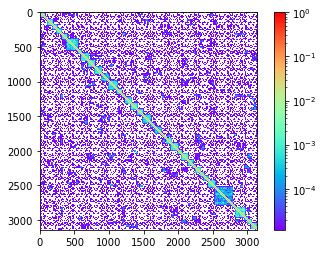

In [109]:
from matplotlib import pyplot as plt, cm
from matplotlib import colors

im = plt.imshow(WN, cmap=cm.rainbow, norm=colors.LogNorm())
plt.colorbar(im)
plt.show()

In [161]:
df['d_l'] = df['o_l'].apply(lambda x: np.random.choice(l_list, size = 1, p=WN[:,x])[0])

In [162]:
df

time   o_l   d_l
0       3  1858  1851
1       7  1858  1858
2       5  1858  1858
3      10  1858  1858
4      22  1858  1887
..    ...   ...   ...
264     3  1858  1858
265     8  1858  1857
266     4  1858  1851
267     7  1858  1830
268     4  1858  1868

[269 rows x 3 columns]

In [163]:
NF_ii = np.array(df)

In [164]:
for (t,o,d) in NF_ii:
    NewInf[d,t] = NewInf[d,t]+1

In [26]:
# NewInf_s = NewInf[:,:60]
# NewInf1 = np.loadtxt('NewInf_r_0.1.csv')
NewInf_s1 = NewInf[:,:60]
# NewInf_s2 = NewInf[:,:60]

In [27]:
daily_per_pop1 = NewInf_s1/pop[:,None]*100000

# daily_per_pop2 = NewInf_s2/pop[:,None]*100000

Text(0, 0.5, 'counties with daily infections per 100000>10')

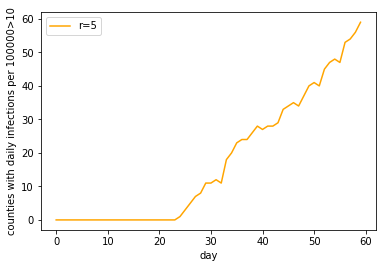

In [29]:
# plt.plot(np.sum(daily_per_pop1>10,axis=0),label='r=0.1',color='green')
plt.plot(np.sum(daily_per_pop1>10,axis=0),label='r=5',color='orange')
plt.legend()
plt.xlabel('day')
plt.ylabel('counties with daily infections per 100000>10')

In [61]:
# np.savetxt('NewInf_r_0.1.csv',NewInf)
np.savetxt('NewInf_r_51.csv',NewInf)